<a href="https://colab.research.google.com/github/Gabzer7/mig-projet/blob/main/affichage_de_20_images_de_tumeurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

# Monter Google Drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/brain_segmentation')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import shutil
import os
import h5py

# 1. Chemins
source_path = '/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/volume_369_slice_154.h5'
local_path = '/content/test_sample.h5'  # On le copie à la racine de la VM

# 2. Vérification et Copie
if os.path.exists(source_path):
    print("Fichier trouvé sur le Drive. Copie en cours vers le disque local...")
    shutil.copy(source_path, local_path)
    print("Copie terminée.")

    # 3. Lecture du fichier local
    try:
        with h5py.File(local_path, 'r') as f:
            print(f"\n--- Succès ! ---")
            print(f"Clés disponibles : {list(f.keys())}")
            for key in f.keys():
                print(f"Shape de '{key}' : {f[key].shape}")
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier local : {e}")

else:
    print(f"ERREUR : Le fichier n'existe pas à cet emplacement :\n{source_path}")
    print("Vérifiez s'il n'y a pas une faute de frappe ou si le dossier 'content/data' est bien correct.")

Fichier trouvé sur le Drive. Copie en cours vers le disque local...
Copie terminée.

--- Succès ! ---
Clés disponibles : ['image', 'mask']
Shape de 'image' : (240, 240, 4)
Shape de 'mask' : (240, 240, 3)


Recherche des fichiers sur le Drive...
Copie de 20 fichiers vers le disque local pour lecture rapide...
Génération des images...


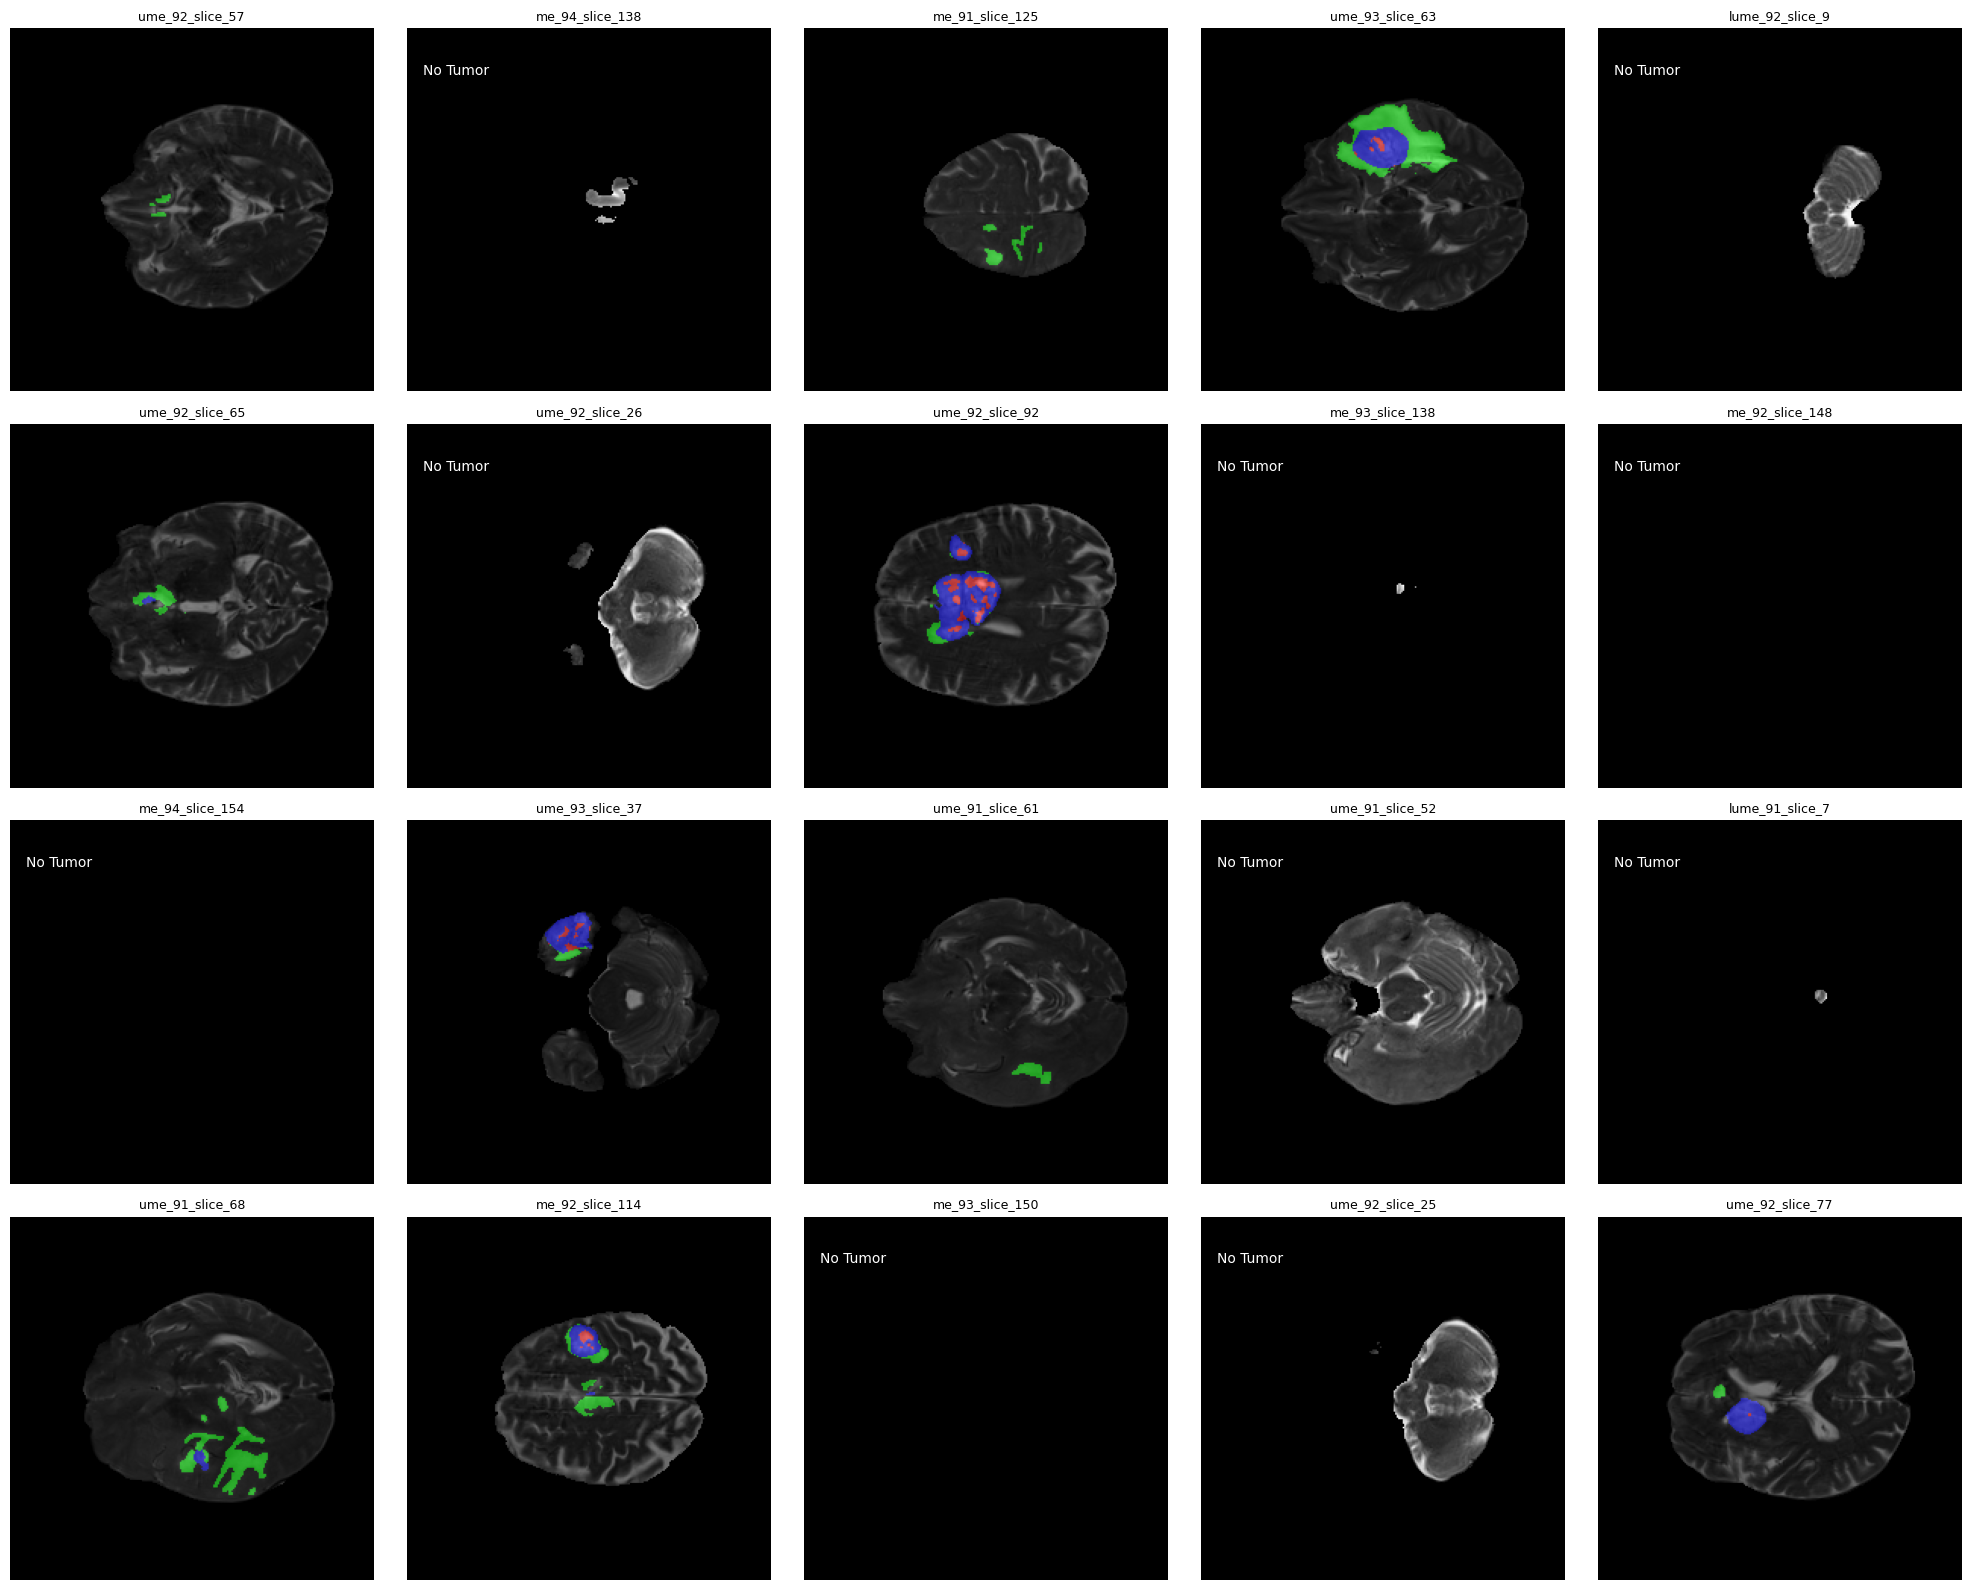

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import shutil

# --- CONFIGURATION ---
# Chemin source (sur votre Google Drive)
SOURCE_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/"
# Chemin local temporaire (sur la VM Colab, pour éviter les erreurs I/O)
LOCAL_TEMP_PATH = "/content/temp_slices_viz/"
NUM_IMAGES = 20

def visualize_batch():
    # 1. Préparation : Copie des fichiers
    if not os.path.exists(LOCAL_TEMP_PATH):
        os.makedirs(LOCAL_TEMP_PATH)

    print("Recherche des fichiers sur le Drive...")
    all_files = glob.glob(os.path.join(SOURCE_DRIVE_PATH, "*.h5"))

    if not all_files:
        print("ERREUR : Aucun fichier trouvé dans le chemin source.")
        return

    # On prend 20 fichiers au hasard ou les premiers
    files_to_process = all_files[:NUM_IMAGES]

    print(f"Copie de {len(files_to_process)} fichiers vers le disque local pour lecture rapide...")
    local_files = []
    for src in files_to_process:
        filename = os.path.basename(src)
        dst = os.path.join(LOCAL_TEMP_PATH, filename)
        # On ne copie que si le fichier n'est pas déjà là
        if not os.path.exists(dst):
            shutil.copy(src, dst)
        local_files.append(dst)

    # 2. Visualisation
    rows = 4
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    axes = axes.flatten()

    print("Génération des images...")

    for i, file_path in enumerate(local_files):
        try:
            with h5py.File(file_path, 'r') as f:
                # Lecture des données
                # Image shape: (240, 240, 4)
                img_data = f['image'][:]
                # Mask shape: (240, 240, 3)
                mask_data = f['mask'][:]

                # --- TRAITEMENT IMAGE ---
                # On prend le dernier canal (index 3) qui est souvent le FLAIR
                # Le FLAIR montre bien l'œdème (zone liquide)
                # Si l'image est noire, essayez l'index 2 (T2)
                background_img = img_data[:, :, 3]

                # --- TRAITEMENT MASQUE ---
                # Le masque est (240, 240, 3). Pour l'afficher en couleur,
                # on s'assure qu'il est float (0.0 à 1.0)
                mask_rgb = mask_data.astype(float)

                # S'il y a de la tumeur sur cette slice
                if np.max(mask_rgb) > 0:
                    # Affichage du fond (Cerveau)
                    axes[i].imshow(background_img, cmap='gray')

                    # Superposition du masque
                    # On affiche les 3 canaux comme du RGB (Rouge, Vert, Bleu)
                    # Alpha 0.5 pour la transparence
                    axes[i].imshow(mask_rgb, alpha=0.5)
                else:
                    # Pas de tumeur sur cette slice, on affiche juste le cerveau
                    axes[i].imshow(background_img, cmap='gray')
                    axes[i].text(10, 30, "No Tumor", color='white', backgroundcolor='black')

                # Titre propre (ex: volume_369_slice_154)
                filename = os.path.basename(file_path).replace('.h5', '')
                axes[i].set_title(filename[-15:], fontsize=9) # On garde la fin du nom
                axes[i].axis('off')

        except Exception as e:
            print(f"Erreur sur {file_path}: {e}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Exécution
if __name__ == "__main__":
    visualize_batch()